In [1]:
import os
import copy
import random
import pandas as pd
import numpy as np
import torch
import torchvision
from skimage.metrics import hausdorff_distance
import matplotlib.pyplot as plt
import torch.optim as optim
from torchvision.io import read_image, ImageReadMode
import torchvision.transforms.functional as TF
from torchvision import transforms as T
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision.utils import make_grid
import torch.nn as nn
import torch.nn.functional as F

In [2]:
torch.manual_seed(42)
random.seed(42)

In [3]:
print(os.listdir("../input"))

['breast-ultrasound-images-dataset']


In [4]:
from os import walk
for (dirpath, dirname, filename) in walk("../input/"):
    print("Directory path: ", dirpath)
    print("Directory name: ", dirname)

Directory path:  ../input/
Directory name:  ['breast-ultrasound-images-dataset']
Directory path:  ../input/breast-ultrasound-images-dataset
Directory name:  ['Dataset_BUSI_with_GT']
Directory path:  ../input/breast-ultrasound-images-dataset/Dataset_BUSI_with_GT
Directory name:  ['benign', 'normal', 'malignant']
Directory path:  ../input/breast-ultrasound-images-dataset/Dataset_BUSI_with_GT/benign
Directory name:  []
Directory path:  ../input/breast-ultrasound-images-dataset/Dataset_BUSI_with_GT/normal
Directory name:  []
Directory path:  ../input/breast-ultrasound-images-dataset/Dataset_BUSI_with_GT/malignant
Directory name:  []


In [5]:
from os import listdir
from pathlib import Path
def load_dir(dir):
    images = []
    masks = []
    resize = T.Resize((128,128))
    for subdir in listdir(dir):
        for file in listdir(f"{dir}/{subdir}"):
            if file.endswith(".png") and "mask" not in file:
                image = read_image(f"{dir}/{subdir}/{file}", ImageReadMode.GRAY)
                image = resize(image)
                image = TF.convert_image_dtype(image, dtype=torch.float32)
                
                filename = file.split(".")[0]
                files_list = list(Path(f"{dir}/{subdir}").rglob(f"{filename}*"))
                masks_list = [f for f in files_list if "mask" in str(f)]

                if len(masks_list) == 1:
                        mask_file = masks_list[0]
                        mask = read_image(f"{mask_file}", ImageReadMode.GRAY)
                        mask = resize(mask)
                        mask = TF.convert_image_dtype(mask, dtype=torch.float32)
                        
                        images.append(image)
                        masks.append(mask)
                        
                else:
                    continue
                    
    return images, masks

def Flip(images, masks, fun):
        flipImage, flipMask = [], []
        for image, mask in zip(images, masks):
            flipImage.append(fun(image))
            flipMask.append(fun(mask))
        return flipImage, flipMask
    
def rotate(images, masks):
        rotImages = []
        rotMasks = []
        for image, mask in zip(images, masks):
            angle = random.randint(-180, 180)
            rotImages.append(TF.rotate(image, angle))
            rotMasks.append(TF.rotate(mask, angle))
        return rotImages, rotMasks
    
def crop(images, masks):
    cropImages, cropMasks = [], []
    for image, mask in zip(images, masks):
        img = torch.stack((image, mask))
        img = T.RandomResizedCrop((128,128))(img)
        cropImages.append(img[0])
        cropMasks.append(img[1])
    return cropImages, cropMasks

class BUSI_dataset(Dataset):
    def __init__(self, path):
        images, masks = load_dir(path)
        
        horFlipImages, horFlipMasks = Flip(images, masks, TF.hflip)
        verFlipImages, verFlipMasks = Flip(images, masks, TF.vflip)
        rotImages, rotMasks = rotate(images, masks)
        cropImages, cropMasks = crop(images, masks)
        
        self.images = images + horFlipImages + verFlipImages + rotImages + cropImages
        self.masks = masks + horFlipMasks + verFlipMasks + rotMasks + cropMasks
    
    def __getitem__(self, index):
        #return self.transform(self.images[index]), self.transform(self.masks[index])
        return self.images[index], self.masks[index]
    
    def __len__(self):
        return len(self.images) 
    
def train_test_split(dataset, split_ratio=0.1):
    length = len(dataset)
    test_size = int(length * split_ratio)
    train_size = length - test_size
    
    return random_split(dataset, [train_size, test_size])

In [6]:
path = "../input/breast-ultrasound-images-dataset/Dataset_BUSI_with_GT"
dataset = BUSI_dataset(path)
#dataLoader = DataLoader(dataset, batch_size=16, shuffle=True, num_workers=4)
trainset, testset = train_test_split(dataset, 0.2)
valset, testset = train_test_split(testset, 0.5)
batch_size = 16
trainLoader = DataLoader(trainset, batch_size, shuffle=True, num_workers=2)
valLoader = DataLoader(valset, batch_size, shuffle=True, num_workers=2)
testLoader = DataLoader(testset, batch_size, shuffle=True, num_workers=2)

In [7]:
print(len(trainset), len(valset), len(testset))

3052 382 381


In [8]:
def show_images(images):
    fig, ax = plt.subplots(figsize=(15, 15))
    ax.set_xticks([]); ax.set_yticks([])
    ax.imshow(make_grid((images.detach()), nrow=8).permute(1, 2, 0))
def show_batch(dl):
    for images, masks in dl:
        show_images(images)
        show_images(masks)
        break

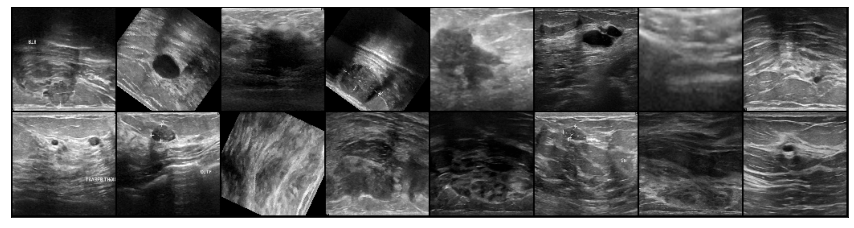

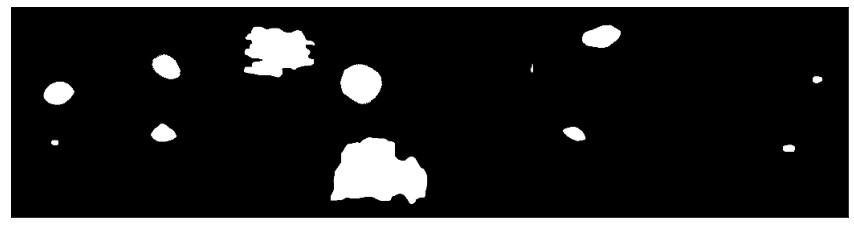

In [9]:
show_batch(trainLoader)

In [10]:
print(trainset[8][1].shape)

torch.Size([1, 128, 128])


In [11]:
## UNET Encoder and decoder utilities
class InitConv(nn.Module):
    def __init__(self, in_channels, out_channels, dropout=0.2):
        super(InitConv,self).__init__()
        
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1)
        self.dropout = dropout
    
    def forward(self, x):
        y = self.conv(x)
        y = F.dropout2d(y, self.dropout)
        return y
    
class EnDeBlock(nn.Module):
    def __init__(self, in_channels):
        super(EnDeBlock,self).__init__()
        
        self.norm1 = nn.BatchNorm2d(in_channels)
        self.relu1 = nn.ReLU(inplace=True)
        self.conv1 = nn.Conv2d(in_channels, in_channels, kernel_size=3, padding=1)
        
        self.norm2 = nn.BatchNorm2d(in_channels)
        self.relu2 = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(in_channels, in_channels, kernel_size=3, padding=1)
    
    def forward(self,x):
        x1 = self.norm1(x)
        x1 = self.relu1(x1)
        x1 = self.conv1(x1)
        y = self.norm2(x1)
        y = self.relu2(y)
        y = self.conv2(y)
        
        y = y + x
        return y
    
class EnDown(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(EnDown,self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=2, padding=1)
    
    def forward(self,x):
        y = self.conv(x)
        return y

class DeUp_Cat(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(DeUp_Cat, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=1)
        self.conv2 = nn.ConvTranspose2d(out_channels, out_channels, kernel_size=2, stride=2)
        self.conv3 = nn.Conv2d(out_channels*2, out_channels, kernel_size=1)
    
    def forward(self, x, prev):
        x1 = self.conv1(x)
        y = self.conv2(x1)
        y = torch.cat((prev, y), dim=1)
        y = self.conv3(y)
        
        return y

class LinearProj(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(LinearProj, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1)
    
    def forward(self, x):
        B, C, H, W = x.shape
        #print(B,C,H,W)
        y = self.conv(x)
        y = y.reshape(B, 512, H*W).permute(0, 2, 1)
        return y

class FeatureMap(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(FeatureMap, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1)
    
    def forward(self, x):
        B, N, C = x.shape
        H = int(N ** 0.5)
        #print(H)
        y = x.permute(0, 2, 1).reshape(B, C, H, N // H)
        y = self.conv(y)
        return y

In [12]:
## Encoder Architecture
class Encoder(nn.Module):
    def __init__(self, in_channels, base_channels=16):
        super(Encoder, self).__init__()
        self.InitConv = InitConv(in_channels, base_channels)
        self.EnBlock1 = EnDeBlock(base_channels)
        self.EnDown1 = EnDown(base_channels, base_channels*2)
        
        self.EnBlock2_1 = EnDeBlock(base_channels*2)
        self.EnBlock2_2 = EnDeBlock(base_channels*2)
        self.EnDown2 = EnDown(base_channels*2, base_channels*4)
        
        self.EnBlock3_1 = EnDeBlock(base_channels*4)
        self.EnBlock3_2 = EnDeBlock(base_channels*4)
        self.EnDown3 = EnDown(base_channels*4, base_channels*8)
        
        self.EnBlock4_1 = EnDeBlock(base_channels*8)
        self.EnBlock4_2 = EnDeBlock(base_channels*8)
    
    def forward(self, x):
        x = self.InitConv(x)
        
        x1_1 = self.EnBlock1(x)
        x1_2 = self.EnDown1(x1_1)
        
        x2_1 = self.EnBlock2_1(x1_2)
        x2_1 = self.EnBlock2_2(x2_1)
        x2_2 = self.EnDown2(x2_1)
        
        x3_1 = self.EnBlock3_1(x2_2)
        x3_1 = self.EnBlock3_2(x3_1)
        x3_2 = self.EnDown3(x3_1)
        
        x4_1 = self.EnBlock4_1(x3_2)
        x4_1 = self.EnBlock4_2(x4_1)
        
        return x1_1, x2_1, x3_1, x4_1

In [13]:
## Transformer architecture
class LearnedPositionalEncoding(nn.Module):
    def __init__(self):
        super(LearnedPositionalEncoding, self).__init__()

        self.position_embeddings = nn.Parameter(torch.zeros(1, 256, 512)) #8x

    def forward(self, x, position_ids=None):

        position_embeddings = self.position_embeddings
        return x + position_embeddings

class SelfAttention(nn.Module):
    def __init__(self, dim, head=8, qkv_bias=False, qkv_scale=None, dropout_rate=0.0):
        super(SelfAttention,self).__init__()
        self.num_head = head
        head_dim = dim // head
        self.scale = qkv_scale or head_dim ** -0.5
        
        self.qkv = nn.Linear(dim, dim*3, bias=qkv_bias)
        self.attn_drop = nn.Dropout(dropout_rate)
        self.proj = nn.Linear(dim, dim)
        self.proj_drop = nn.Dropout(dropout_rate)
    
    def forward(self, x):
        B, N, C = x.shape
        qkv = self.qkv(x).reshape(B, N, 3, self.num_head, C // self.num_head).permute(2,0,3,1,4)
        
        q, k, v = qkv[0], qkv[1], qkv[2]
        attn = (q @ k.transpose(-2,-1)) * self.scale
        attn = attn.softmax(dim=-1)
        attn = self.attn_drop(attn)
        
        x = (attn @ v).transpose(1, 2).reshape(B, N, C)
        x = self.proj(x)
        x = self.proj_drop(x)
        
        return x
    
class FeedForward(nn.Module):
    def __init__(self, dim, hidden_dim, dropout_rate):
        super(FeedForward, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(dim, hidden_dim),
            nn.GELU(),
            nn.Dropout(p=dropout_rate),
            nn.Linear(hidden_dim, dim),
            nn.Dropout(p=dropout_rate)
        )
    
    def forward(self, x):
        return self.net(x)

class TransformerLayer(nn.Module):
    def __init__(self, dim, heads, ffn_hidden_dim, ffn_dropout_rate, attn_dropout_rate):
        super(TransformerLayer, self).__init__()
        self.attn = SelfAttention(dim, heads, dropout_rate=attn_dropout_rate)
        self.norm1 = nn.LayerNorm(dim)
        self.drop = nn.Dropout(p=ffn_dropout_rate)
        self.ffn = FeedForward(dim, ffn_hidden_dim, ffn_dropout_rate)
        self.norm2 = nn.LayerNorm(dim)
    
    def forward(self, x):
        y = self.drop(self.attn(self.norm1(x)))
        y = y + x
        z = self.ffn(self.norm2(y))
        z = z + y
        
        return z

def clones(module, N):
    return nn.ModuleList([copy.deepcopy(module) for _ in range(N)])

class TransformerModel(nn.Module):
    def __init__(self, dim, num_layers, heads, ffn_hidden_dim, ffn_dropout_rate=0.1, attn_dropout_rate=0.1):
        super(TransformerModel, self).__init__()
        layer = TransformerLayer(dim, heads, ffn_hidden_dim, ffn_dropout_rate, attn_dropout_rate)
        self.layers = clones(layer, num_layers)
        self.norm = nn.LayerNorm(dim)
    
    def forward(self, x):
        for layer in self.layers:
            x = layer(x)
        return self.norm(x)

In [14]:
## Decoder Architecture

class Decoder(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(Decoder, self).__init__()
        
        self.DeBlock1_1 = EnDeBlock(in_channels)
        self.DeBlock1_2 = EnDeBlock(in_channels)
        self.UpSample1 = DeUp_Cat(in_channels, in_channels//2)
        
        self.DeBlock2 = EnDeBlock(in_channels//2)
        self.UpSample2 = DeUp_Cat(in_channels//2, in_channels//4)
        
        self.DeBlock3 = EnDeBlock(in_channels//4)
        self.UpSample3 = DeUp_Cat(in_channels//4, in_channels//8)
        
        self.DeBlock4 = EnDeBlock(in_channels//8)
        self.EndConv = nn.Conv2d(in_channels//8, out_channels, kernel_size=1)
        self.sigmoid = nn.Sigmoid()
        
    def forward(self, x1_1, x2_1, x3_1, x):
        x = self.DeBlock1_1(x)
        x = self.DeBlock1_2(x)
        x = self.UpSample1(x, x3_1)
        
        x = self.DeBlock2(x)
        x = self.UpSample2(x, x2_1)
        
        x = self.DeBlock3(x)
        x = self.UpSample3(x, x1_1)
        
        x = self.DeBlock4(x)
        x = self.EndConv(x)
        x = self.sigmoid(x)
        return x



In [15]:
## Complete architecture
class EncoderDecoder(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(EncoderDecoder, self).__init__()
        
        self.Encoder = Encoder(in_channels)
        self.LinearProj = LinearProj(128, 512)
        self.PositionEmb = LearnedPositionalEncoding()
        self.Transformer = TransformerModel(dim=512, num_layers=4, heads=8, ffn_hidden_dim=4096)
        self.FeatureMap = FeatureMap(512, 128)
        self.Decoder = Decoder(128, out_channels)
    
    def forward(self, x):
        x1, x2, x3, y = self.Encoder(x)
        #print(x)
        y = self.LinearProj(y)
        #print(y)
        y = self.PositionEmb(y)
        #print(y)
        y = self.Transformer(y)
        #print(y)
        y = self.FeatureMap(y)
        #print(y)
        y = self.Decoder(x1, x2, x3, y)
        #print(y)
        return y

In [16]:
## Loss functions
class DiceLoss(nn.Module):
    def __init__(self, weight=None, size_average=True):
        super(DiceLoss, self).__init__()

    def forward(self, inputs, targets, smooth=1):    
        
        intersection = torch.sum((inputs * targets), dim=(1,2,3))
        union = torch.sum(inputs, dim=(1,2,3)) + torch.sum(targets, dim=(1,2,3))
        dice = torch.mean((2.*intersection + smooth)/(union + smooth))  
        #print(dice)
        return 1 - dice

class LogCoshDiceLoss(nn.Module):
    def __init__(self, weight=None, size_average=True):
        super(LogCoshDiceLoss, self).__init__()
        self.diceLoss = DiceLoss()
    
    def forward(self, inputs, targets):
        loss = self.diceLoss(inputs, targets)
        return torch.log(torch.cosh(loss))

class BCE_DiceCombineLoss(nn.Module):
    def __init__(self, weight=0.01):
        super(BCE_DiceCombineLoss, self).__init__()
        self.weight = weight
        self.BCE = nn.BCELoss()
        self.DiceLoss = DiceLoss()
    
    def forward(self, inputs, targets):
        return self.weight * self.BCE(inputs, targets) + (1-self.weight) * self.DiceLoss(inputs, targets)
        

In [17]:
def adjust_learning_rate(optimizer, epoch, max_epoch, init_lr, power=0.9):
    for param_group in optimizer.param_groups:
        param_group['lr'] = round(init_lr * np.power(1-(epoch) / max_epoch, power), 8)

In [18]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = EncoderDecoder(1, 1).to(device)
criterion = BCE_DiceCombineLoss(0.1).to(device)
learning_rate = 0.00003
optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-2)
num_epochs = 100
trainSteps = len(trainset) // batch_size
testSteps = len(valset) // batch_size

H = {"train_loss": [], "val_loss": []}

for e in range(num_epochs):
    train_loss = 0.0
    val_loss = 0.0
    
    model.train()
    adjust_learning_rate(optimizer, e, num_epochs, learning_rate)
    
    for i, (image, mask) in enumerate(trainLoader):
        (image, mask) = (image.to(device), mask.to(device))
        output = model(image)
        
        loss = criterion(output, mask)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        train_loss += loss.detach().item()
    
    with torch.no_grad():
        model.eval()
        
        for (image, mask) in valLoader:
            (image, mask) = (image.to(device), mask.to(device))
            pred = model(image)
            p_loss = criterion(pred, mask)
            val_loss += p_loss.item()
    
        avgTrainloss = train_loss/trainSteps
        avgValloss = val_loss/testSteps
    
    H["train_loss"].append(avgTrainloss)
    H["val_loss"].append(avgValloss)
    
    print('Epoch {:.0f}/{:.0f} : Training loss: {:.4f} | Validation loss: {:.4f}'.format(e, num_epochs, avgTrainloss, avgValloss))

Epoch 0/100 : Training loss: 0.8537 | Validation loss: 0.8769
Epoch 1/100 : Training loss: 0.8425 | Validation loss: 0.8701
Epoch 2/100 : Training loss: 0.8367 | Validation loss: 0.8616
Epoch 3/100 : Training loss: 0.7876 | Validation loss: 0.7387
Epoch 4/100 : Training loss: 0.6490 | Validation loss: 0.6312
Epoch 5/100 : Training loss: 0.5422 | Validation loss: 0.5872
Epoch 6/100 : Training loss: 0.4889 | Validation loss: 0.5458
Epoch 7/100 : Training loss: 0.4647 | Validation loss: 0.4880
Epoch 8/100 : Training loss: 0.4530 | Validation loss: 0.4926
Epoch 9/100 : Training loss: 0.4329 | Validation loss: 0.4595
Epoch 10/100 : Training loss: 0.4273 | Validation loss: 0.4538
Epoch 11/100 : Training loss: 0.4167 | Validation loss: 0.4594
Epoch 12/100 : Training loss: 0.4138 | Validation loss: 0.4486
Epoch 13/100 : Training loss: 0.4121 | Validation loss: 0.4497
Epoch 14/100 : Training loss: 0.3964 | Validation loss: 0.4448
Epoch 15/100 : Training loss: 0.3919 | Validation loss: 0.4782
Ep

In [19]:
def modelTest(testset, testLoader):
    testSize = len(testset) // batch_size
    test_loss = 0.0
    haus_distance = 0.0
    test_criterion = DiceLoss().to(device)
    with torch.no_grad():
        model.eval()

        for (image, mask) in testLoader:
            (image, mask) = (image.to(device), mask.to(device))
            pred = model(image)

            p_loss = test_criterion(pred, mask)
            test_loss += p_loss.item()
            haus_distance += hausdorff_distance(pred.to("cpu").numpy(), mask.to("cpu").numpy())
        test_loss /= testSize
        haus_distance /= len(testset)
    print("Test Set Dice loss: {:.4f}, Average Hausdorff distance: {:.4f}".format(test_loss, haus_distance))

In [20]:
modelTest(trainset, trainLoader)
modelTest(testset, testLoader)

Test Set Dice loss: 0.1567, Average Hausdorff distance: 2.5492
Test Set Dice loss: 0.3174, Average Hausdorff distance: 2.6416


In [21]:
def show_pred(dl):
    for (image, mask) in dl:
        image, mask = image.to(device), mask.to(device)
        output = model(image)
        output, image, mask = output.to("cpu"), image.to("cpu"), mask.to("cpu")
        show_images(image)
        show_images(mask)
        show_images(output)
        break

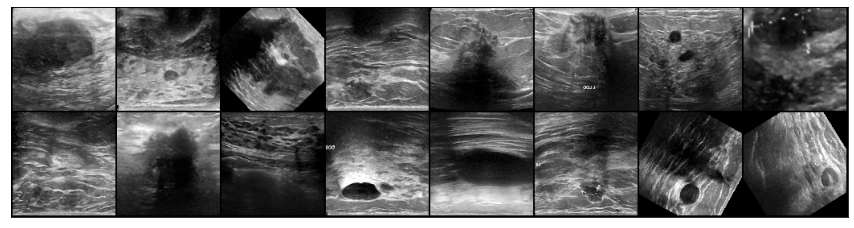

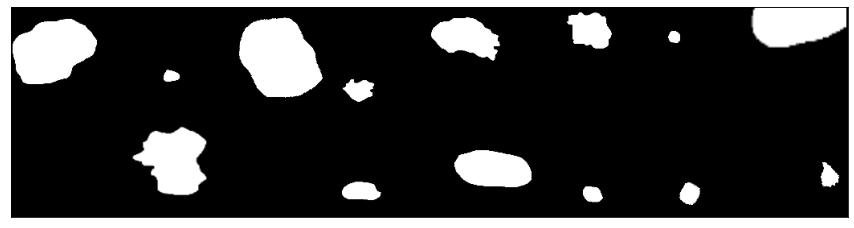

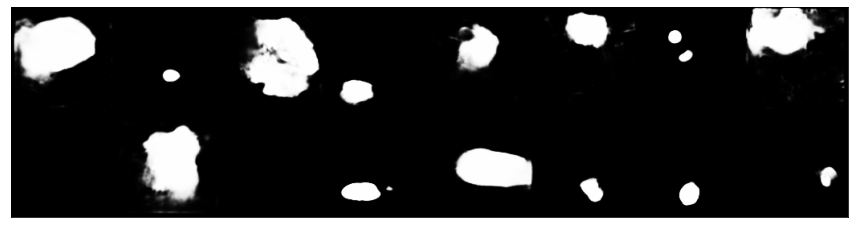

In [22]:
show_pred(testLoader)